In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import torch

torch.set_printoptions(edgeitems=2)
torch.manual_seed(123)

In [2]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']


In [3]:
from torchvision import datasets, transforms
cifar10 = datasets.CIFAR10(
    'data', train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))


Files already downloaded and verified


In [4]:
cifar10_val = datasets.CIFAR10(
    'data', train=False, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

In [5]:
label_map = {6: 0, 9: 1}
class_names = ['airplane', 'bird']
cifar2 = [(img, label_map[label])
          for img, label in cifar10 
          if label in [6, 9]]
cifar2_val = [(img, label_map[label])
              for img, label in cifar10_val
              if label in [6, 9]]

In [6]:
import torch.nn as nn

n_out = 2

model = nn.Sequential(
            nn.Linear(
                3072,  # <1>
                512,   # <2>
            ),
            nn.Tanh(),
            nn.Linear(
                512,   # <2>
                n_out, # <3>
            )
        )

In [7]:
def softmax(x):
    return torch.exp(x) / torch.exp(x).sum()

In [8]:
x = torch.tensor([1.0, 2.0, 3.0])

softmax(x)

tensor([0.0900, 0.2447, 0.6652])

In [9]:
softmax(x).sum()

tensor(1.)

In [10]:
softmax = nn.Softmax(dim=1)

x = torch.tensor([[1.0, 2.0, 3.0],
                  [1.0, 2.0, 3.0]])

softmax(x)

tensor([[0.0900, 0.2447, 0.6652],
        [0.0900, 0.2447, 0.6652]])

In [11]:
model = nn.Sequential(
            nn.Linear(3072, 512),
            nn.Tanh(),
            nn.Linear(512, 2),
            nn.Softmax(dim=1))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


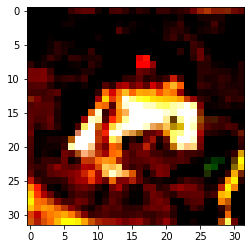

In [12]:
img, _ = cifar2[0]

plt.imshow(img.permute(1, 2, 0))
plt.show()

In [13]:
img_batch = img.view(-1).unsqueeze(0)

In [14]:
out = model(img_batch)
out

tensor([[0.4813, 0.5187]], grad_fn=<SoftmaxBackward>)

In [15]:

_, index = torch.max(out, dim=1)

index

tensor([1])

In [16]:
out = torch.tensor([
    [0.6, 0.4],
    [0.9, 0.1],
    [0.3, 0.7],
    [0.2, 0.8],
])
class_index = torch.tensor([0, 0, 1, 1]).unsqueeze(1)

truth = torch.zeros((4,2))
truth.scatter_(dim=1, index=class_index, value=1.0)
truth

tensor([[1., 0.],
        [1., 0.],
        [0., 1.],
        [0., 1.]])

In [17]:

def mse(out):
    return ((out - truth) ** 2).sum(dim=1).mean()
mse(out)

tensor(0.1500)

In [18]:
out.gather(dim=1, index=class_index)

tensor([[0.6000],
        [0.9000],
        [0.7000],
        [0.8000]])

In [19]:
def likelihood(out):
    prod = 1.0
    for x in out.gather(dim=1, index=class_index):
        prod *= x
    return prod

likelihood(out)

tensor([0.3024])

In [20]:
def neg_log_likelihood(out):
    return -likelihood(out).log()

neg_log_likelihood(out)

tensor([1.1960])

In [21]:

out0 = out.clone().detach()
out0[0] = torch.tensor([0.9, 0.1]) # more right

out2 = out.clone().detach()
out2[0] = torch.tensor([0.4, 0.6]) # slightly wrong

out3 = out.clone().detach()
out3[0] = torch.tensor([0.1, 0.9]) # very wrong

mse_comparison = torch.tensor([mse(o) for o in [out0, out, out2, out3]])
mse_comparison

tensor([0.0750, 0.1500, 0.2500, 0.4750])

In [22]:
((mse_comparison / mse_comparison[1]) - 1) * 100

tensor([-50.0000,   0.0000,  66.6667, 216.6667])

In [23]:
nll_comparison = torch.tensor([neg_log_likelihood(o) 
                               for o in [out0, out, out2, out3]])
nll_comparison

tensor([0.7905, 1.1960, 1.6015, 2.9878])

In [24]:
((nll_comparison / nll_comparison[1]) - 1) * 100

tensor([-33.9016,   0.0000,  33.9016, 149.8121])

In [25]:

softmax = nn.Softmax(dim=1)

log_softmax = nn.LogSoftmax(dim=1)

x = torch.tensor([[0.0, 104.0]])

softmax(x)

tensor([[0., 1.]])

In [26]:
softmax = nn.Softmax(dim=1)

log_softmax = nn.LogSoftmax(dim=1)

x = torch.tensor([[0.0, 104.0]])

softmax(x)

tensor([[0., 1.]])

In [27]:
torch.log(softmax(x))

tensor([[-inf, 0.]])

In [28]:
log_softmax(x)

tensor([[-104.,    0.]])

In [29]:
torch.exp(log_softmax(x))

tensor([[0., 1.]])

In [30]:
model = nn.Sequential(
            nn.Linear(3072, 512),
            nn.Tanh(),
            nn.Linear(512, 2),
            nn.LogSoftmax(dim=1))

In [31]:
loss = nn.NLLLoss()

In [32]:
img, label = cifar2[0]

out = model(img.view(-1).unsqueeze(0))

loss(out, torch.tensor([label]))

tensor(0.8378, grad_fn=<NllLossBackward>)

In [33]:
import torch
import torch.nn as nn
import torch.optim as optim
import time

train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=True)

model = nn.Sequential(
            nn.Linear(3072, 512),
            nn.Tanh(),
            nn.Linear(512, 4),
            nn.LogSoftmax(dim=1))

learning_rate = 1e-2

optimizer = optim.SGD(model.parameters(), lr=learning_rate)

loss_fn = nn.NLLLoss()

n_epochs = 200
t1 = time.time()
for epoch in range(n_epochs):
    for imgs, labels in train_loader:
        t2 = time.time()
        outputs = model(imgs.view(imgs.shape[0], -1))
        loss = loss_fn(outputs, labels)
                
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        t2 = time.time()
        t3 = t1 -t2
    print("Epoch: %d, Loss: %f" % (epoch, float(loss)))
    print ("t3:", t3 )

Epoch: 0, Loss: 0.273059
t3: -2.748128652572632
Epoch: 1, Loss: 0.267634
t3: -4.637125253677368
Epoch: 2, Loss: 0.103204
t3: -6.512107849121094
Epoch: 3, Loss: 0.304981
t3: -8.394071817398071
Epoch: 4, Loss: 0.193909
t3: -10.310943841934204
Epoch: 5, Loss: 0.079469
t3: -12.195899724960327
Epoch: 6, Loss: 0.114009
t3: -14.060909509658813
Epoch: 7, Loss: 0.055402
t3: -15.881039381027222
Epoch: 8, Loss: 0.143898
t3: -17.71313714981079
Epoch: 9, Loss: 0.206610
t3: -19.56968092918396
Epoch: 10, Loss: 0.187704
t3: -21.407308340072632
Epoch: 11, Loss: 0.272994
t3: -23.24490761756897
Epoch: 12, Loss: 0.202973
t3: -25.1219425201416
Epoch: 13, Loss: 0.267931
t3: -26.93010640144348
Epoch: 14, Loss: 0.215639
t3: -28.75274419784546
Epoch: 15, Loss: 0.428310
t3: -30.553974390029907
Epoch: 16, Loss: 0.206990
t3: -32.4110062122345
Epoch: 17, Loss: 0.236499
t3: -34.242106437683105
Epoch: 18, Loss: 0.128360
t3: -36.066227197647095
Epoch: 19, Loss: 0.151824
t3: -37.88735365867615
Epoch: 20, Loss: 0.16114

In [34]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=True)

In [35]:
import torch
import torch.nn as nn
import torch.optim as optim

train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=True)

model = nn.Sequential(
            nn.Linear(3072, 128),
            nn.Tanh(),
            nn.Linear(128,2),
            nn.LogSoftmax(dim=1))

learning_rate = 1e-2

optimizer = optim.SGD(model.parameters(), lr=learning_rate)

loss_fn = nn.NLLLoss()

n_epochs = 200

for epoch in range(n_epochs):
    for imgs, labels in train_loader:
        outputs = model(imgs.view(imgs.shape[0], -1))
        loss = loss_fn(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print("Epoch: %d, Loss: %f" % (epoch, float(loss)))

Epoch: 0, Loss: 0.311581
Epoch: 1, Loss: 0.253266
Epoch: 2, Loss: 0.148927
Epoch: 3, Loss: 0.173660
Epoch: 4, Loss: 0.203652
Epoch: 5, Loss: 0.196086
Epoch: 6, Loss: 0.166124
Epoch: 7, Loss: 0.148210
Epoch: 8, Loss: 0.272409
Epoch: 9, Loss: 0.360616
Epoch: 10, Loss: 0.195339
Epoch: 11, Loss: 0.174894
Epoch: 12, Loss: 0.120948
Epoch: 13, Loss: 0.100845
Epoch: 14, Loss: 0.081434
Epoch: 15, Loss: 0.253963
Epoch: 16, Loss: 0.070082
Epoch: 17, Loss: 0.059574
Epoch: 18, Loss: 0.240505
Epoch: 19, Loss: 0.334050
Epoch: 20, Loss: 0.038998
Epoch: 21, Loss: 0.190333
Epoch: 22, Loss: 0.157580
Epoch: 23, Loss: 0.087759
Epoch: 24, Loss: 0.134370
Epoch: 25, Loss: 0.057698
Epoch: 26, Loss: 0.102789
Epoch: 27, Loss: 0.053423
Epoch: 28, Loss: 0.108020
Epoch: 29, Loss: 0.028507
Epoch: 30, Loss: 0.090682
Epoch: 31, Loss: 0.061485
Epoch: 32, Loss: 0.115234
Epoch: 33, Loss: 0.037408
Epoch: 34, Loss: 0.059182
Epoch: 35, Loss: 0.069342
Epoch: 36, Loss: 0.078443
Epoch: 37, Loss: 0.102015
Epoch: 38, Loss: 0.069

In [36]:

import torch
import torch.nn as nn
import torch.optim as optim

train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=True)

model = nn.Sequential(
            nn.Linear(3072, 512),
            nn.Tanh(),
            nn.Linear(512, 2),
            nn.LogSoftmax(dim=1))

learning_rate = 1e-2

optimizer = optim.SGD(model.parameters(), lr=learning_rate)

loss_fn = nn.NLLLoss()

n_epochs = 200

for epoch in range(n_epochs):
    for imgs, labels in train_loader:
        outputs = model(imgs.view(imgs.shape[0], -1))
        loss = loss_fn(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print("Epoch: %d, Loss: %f" % (epoch, float(loss)))

Epoch: 0, Loss: 0.495928
Epoch: 1, Loss: 0.437014
Epoch: 2, Loss: 0.240798
Epoch: 3, Loss: 0.290249
Epoch: 4, Loss: 0.107197
Epoch: 5, Loss: 0.241871
Epoch: 6, Loss: 0.095160
Epoch: 7, Loss: 0.180488
Epoch: 8, Loss: 0.231711
Epoch: 9, Loss: 0.164056
Epoch: 10, Loss: 0.230373
Epoch: 11, Loss: 0.104626
Epoch: 12, Loss: 0.209761
Epoch: 13, Loss: 0.302432
Epoch: 14, Loss: 0.161054
Epoch: 15, Loss: 0.106048
Epoch: 16, Loss: 0.209266
Epoch: 17, Loss: 0.153772
Epoch: 18, Loss: 0.104511
Epoch: 19, Loss: 0.078554
Epoch: 20, Loss: 0.149169
Epoch: 21, Loss: 0.100369
Epoch: 22, Loss: 0.358472
Epoch: 23, Loss: 0.043414
Epoch: 24, Loss: 0.107459
Epoch: 25, Loss: 0.079796
Epoch: 26, Loss: 0.017831
Epoch: 27, Loss: 0.312643
Epoch: 28, Loss: 0.048439
Epoch: 29, Loss: 0.047229
Epoch: 30, Loss: 0.060887
Epoch: 31, Loss: 0.054336
Epoch: 32, Loss: 0.037971
Epoch: 33, Loss: 0.132314
Epoch: 34, Loss: 0.065519
Epoch: 35, Loss: 0.026809
Epoch: 36, Loss: 0.072250
Epoch: 37, Loss: 0.024997
Epoch: 38, Loss: 0.055

In [37]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=False)

correct = 0
total = 0

with torch.no_grad():
    for imgs, labels in train_loader:
        outputs = model(imgs.view(imgs.shape[0], -1))
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())
        
print("Accuracy: %f" % (correct / total))

Accuracy: 1.000000


In [38]:
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64,
                                         shuffle=False)

correct = 0
total = 0

with torch.no_grad():
    for imgs, labels in val_loader:
        outputs = model(imgs.view(imgs.shape[0], -1))
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())
        
print("Accuracy: %f" % (correct / total))

Accuracy: 0.910000


In [39]:
model = nn.Sequential(
            nn.Linear(3072, 1024),
            nn.Tanh(),
            nn.Linear(1024, 512),
            nn.Tanh(),
            nn.Linear(512, 128),
            nn.Tanh(),
            nn.Linear(128, 2),
            nn.LogSoftmax(dim=1))

In [40]:
model = nn.Sequential(
            nn.Linear(3072, 1024),
            nn.Tanh(),
            nn.Linear(1024, 512),
            nn.Tanh(),
            nn.Linear(512, 128),
            nn.Tanh(),
            nn.Linear(128, 2))

loss_fn = nn.CrossEntropyLoss()

In [41]:

import torch
import torch.nn as nn
import torch.optim as optim

train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=True)

model = nn.Sequential(
            nn.Linear(3072, 1024),
            nn.Tanh(),
            nn.Linear(1024, 512),
            nn.Tanh(),
            nn.Linear(512, 128),
            nn.Tanh(),
            nn.Linear(128, 2))

learning_rate = 1e-2

optimizer = optim.SGD(model.parameters(), lr=learning_rate)

loss_fn = nn.CrossEntropyLoss()

n_epochs = 200

for epoch in range(n_epochs):
    for imgs, labels in train_loader:
        outputs = model(imgs.view(imgs.shape[0], -1))
        loss = loss_fn(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        

    print("Epoch: %d, Loss: %f" % (epoch, float(loss)))

Epoch: 0, Loss: 0.243899
Epoch: 1, Loss: 0.322556
Epoch: 2, Loss: 0.554614
Epoch: 3, Loss: 0.205421
Epoch: 4, Loss: 0.146262
Epoch: 5, Loss: 0.204681
Epoch: 6, Loss: 0.109278
Epoch: 7, Loss: 0.166629
Epoch: 8, Loss: 0.116716
Epoch: 9, Loss: 0.520668
Epoch: 10, Loss: 0.104574
Epoch: 11, Loss: 0.095384
Epoch: 12, Loss: 0.082692
Epoch: 13, Loss: 0.129466
Epoch: 14, Loss: 0.405595
Epoch: 15, Loss: 0.040573
Epoch: 16, Loss: 0.044479
Epoch: 17, Loss: 0.064385
Epoch: 18, Loss: 0.266587
Epoch: 19, Loss: 0.606524
Epoch: 20, Loss: 0.049630
Epoch: 21, Loss: 0.228701
Epoch: 22, Loss: 0.152616
Epoch: 23, Loss: 0.023880
Epoch: 24, Loss: 0.106237
Epoch: 25, Loss: 0.019835
Epoch: 26, Loss: 0.152911
Epoch: 27, Loss: 0.226336
Epoch: 28, Loss: 0.010262
Epoch: 29, Loss: 0.105385
Epoch: 30, Loss: 0.002569
Epoch: 31, Loss: 0.123275
Epoch: 32, Loss: 0.073301
Epoch: 33, Loss: 0.015930
Epoch: 34, Loss: 0.036814
Epoch: 35, Loss: 0.010538
Epoch: 36, Loss: 0.005881
Epoch: 37, Loss: 0.008337
Epoch: 38, Loss: 0.007

In [42]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=False)

correct = 0
total = 0

with torch.no_grad():
    for imgs, labels in train_loader:
        outputs = model(imgs.view(imgs.shape[0], -1))
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())
        
print("Accuracy: %f" % (correct / total))

Accuracy: 1.000000


In [43]:
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64,
                                         shuffle=False)

correct = 0
total = 0

with torch.no_grad():
    for imgs, labels in val_loader:
        outputs = model(imgs.view(imgs.shape[0], -1))
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())
        
print("Accuracy: %f" % (correct / total))

Accuracy: 0.903500


In [44]:
sum([p.numel() for p in model.parameters()])

3737474

In [45]:

sum([p.numel() for p in model.parameters() if p.requires_grad == True])

3737474

In [46]:
first_model = nn.Sequential(
                nn.Linear(3072, 512),
                nn.Tanh(),
                nn.Linear(512, 2),
                nn.LogSoftmax(dim=1))

sum([p.numel() for p in first_model.parameters()])

1574402

In [47]:
sum([p.numel() for p in nn.Linear(3072, 512).parameters()])


1573376

In [48]:
sum([p.numel() for p in nn.Linear(3072, 1024).parameters()])


3146752

In [49]:
linear = nn.Linear(3072, 1024)

linear.weight.shape, linear.bias.shape


(torch.Size([1024, 3072]), torch.Size([1024]))

In [50]:
conv = nn.Conv2d(3, 16, kernel_size=3)

In [51]:
conv.weight.shape

torch.Size([16, 3, 3, 3])

In [52]:
img, _ = cifar2[0]

output = conv(img.unsqueeze(0))

In [53]:
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 16, 30, 30]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


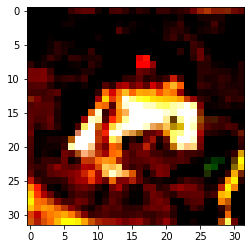

In [54]:
plt.imshow(img.permute(1, 2, 0), cmap='gray')
plt.show()

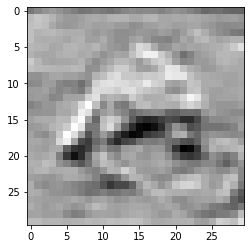

In [55]:
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.show()

In [56]:
output.shape

torch.Size([1, 16, 30, 30])

In [57]:
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1)

In [58]:
output = conv(img.unsqueeze(0))

output.shape

torch.Size([1, 1, 32, 32])

In [59]:
with torch.no_grad():
    conv.bias.zero_()

In [60]:
with torch.no_grad():
    conv.weight.fill_(1.0 / 9.0)

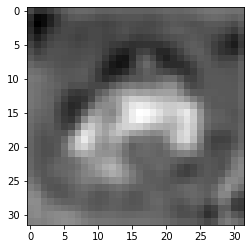

In [61]:

output = conv(img.unsqueeze(0))
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.show()

In [62]:
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1)

with torch.no_grad():
    conv.weight[:] = torch.tensor([[-1.0, 0.0, 1.0],
                                   [-1.0, 0.0, 1.0],
                                   [-1.0, 0.0, 1.0]])
    conv.bias.zero_()

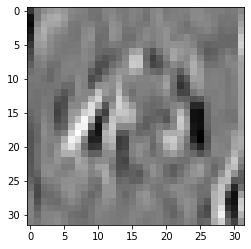

In [63]:
output = conv(img.unsqueeze(0))
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.show()

In [64]:
pool = nn.MaxPool2d(2)

In [65]:
output = pool(img.unsqueeze(0))

output.shape

torch.Size([1, 3, 16, 16])